# Setup

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer , AutoModel 
import torch
import numpy as np
import os 

device = "cuda" if torch.cuda.is_available() else "cpu" 
print(device)

cuda


In [3]:
def test_model_load():
    model_name = "distilbert-base-uncased"
    
    print("Loading tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    print("Loading model...")
    model = AutoModel.from_pretrained(model_name)
    model.eval()  # inference mode

    text = "This is a test sentence for feature extraction."

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    
    with torch.no_grad():
        outputs = model(**inputs)
        if hasattr(outputs, "pooler_output") and outputs.pooler_output is not None:
            emb = outputs.pooler_output.squeeze()
        else:
            emb = outputs.last_hidden_state.mean(dim=1).squeeze()

    print(f"Embedding shape: {emb.shape}")
    print(f"Embedding snippet: {emb[:5]}")

# Lets see if we crash the kernel ? 

In [4]:
test_model_load()

Loading tokenizer...
Loading model...
Embedding shape: torch.Size([768])
Embedding snippet: tensor([-0.0899, -0.2205, -0.0564, -0.0175,  0.0988])


# Ok we are good to go locally 

In [8]:
model_name = "distilbert-base-uncased" 

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_name)

print("Loading model...")
model = AutoModel.from_pretrained(model_name)
model.to(device)
model.eval()  # inference mode  


Loading tokenizer...
Loading model...


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

# Load the dataset

In [9]:
dataset = load_dataset("emotion", split="train")
dataset[0]


{'text': 'i didnt feel humiliated', 'label': 0}

## Apply the feature extraction to extract hidden states from the model 
later we will use these hidden states as features for classification using classical ML models 

In [10]:
def extract_embedding(text, tokenizer, model, device, max_length=128):
    # Tokenize text
    inputs = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    )
    
    # Move tensors to device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Inference (no gradients)
    with torch.no_grad():
        outputs = model(**inputs)
        
        # Case 1: Use pooler output (if it exists and is not None)
        if hasattr(outputs, "pooler_output") and outputs.pooler_output is not None:
            embedding = outputs.pooler_output.squeeze()

        # Case 2: Use CLS token (first token) if available
        elif outputs.last_hidden_state.shape[1] > 0:
            embedding = outputs.last_hidden_state[:, 0, :].squeeze()

        # Fallback: Use mean pooling over all tokens
        else:
            embedding = outputs.last_hidden_state.mean(dim=1).squeeze()

    # Detach, move to CPU, convert to NumPy
    return embedding.detach().cpu().numpy()


In [12]:
text = "I feel very excited about the future."
emb = extract_embedding(text, tokenizer, model, device)
print(emb.shape)  # must be (768,)


(768,)


# Apply the feature extraction to the dataset

In [15]:
def batch_extract(batch):
    embeddings = []
    for text in batch["text"]:
        emb = extract_embedding(text, tokenizer, model, device)
        embeddings.append(emb)
    return {"embedding": embeddings}


In [16]:


# Apply mapping
embedded_dataset = dataset.map(
    batch_extract,
    batched=True,
    batch_size=8,  # Tune this depending on your VRAM
    remove_columns=["text"]  # optional, keeps only label + embedding
)


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Lets see the results of the feature extraction

In [18]:
embedded_dataset["embedding"][0]

[-0.11675151437520981,
 0.09857115149497986,
 -0.12962952256202698,
 -0.09501790255308151,
 -0.28083452582359314,
 -0.13221542537212372,
 0.22748209536075592,
 0.23100337386131287,
 0.16752298176288605,
 -0.24662652611732483,
 0.021755008026957512,
 -0.1020004004240036,
 -0.1809791922569275,
 0.2235109508037567,
 0.20275351405143738,
 0.11693044751882553,
 -0.0006956505822017789,
 0.1202535331249237,
 -0.00014269514940679073,
 -0.06074290722608566,
 -0.14381593465805054,
 -0.3120141625404358,
 -0.10877186059951782,
 0.11821557581424713,
 -0.07393912971019745,
 0.07263513654470444,
 0.2131928652524948,
 -0.2956962585449219,
 0.10432228446006775,
 -0.14979593455791473,
 0.1191268116235733,
 0.1355866938829422,
 -0.20511923730373383,
 0.07998280227184296,
 -0.12340020388364792,
 0.0249957088381052,
 0.011948119848966599,
 0.010090289637446404,
 0.1374000608921051,
 -0.013440425507724285,
 -0.11265956610441208,
 -0.0776466429233551,
 -0.13006697595119476,
 -0.07168767601251602,
 0.08529749

In [19]:
import numpy as np

X = np.stack(embedded_dataset["embedding"])
y = np.array(embedded_dataset["label"])

np.save("train_features.npy", X)
np.save("train_labels.npy", y)

print("✅ Saved train features and labels.")


✅ Saved train features and labels.


# Apply simple logistic regression to the features

In [24]:
# Train/test split
from sklearn.model_selection import train_test_split 

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train classifier
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(class_weight="balanced", max_iter=3000)
clf.fit(X_train, y_train)

# Evaluate
from sklearn.metrics import classification_report
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.56      0.63       933
           1       0.78      0.63      0.70      1072
           2       0.38      0.58      0.46       261
           3       0.52      0.64      0.57       432
           4       0.48      0.54      0.51       387
           5       0.30      0.63      0.41       115

    accuracy                           0.60      3200
   macro avg       0.53      0.60      0.55      3200
weighted avg       0.64      0.60      0.61      3200



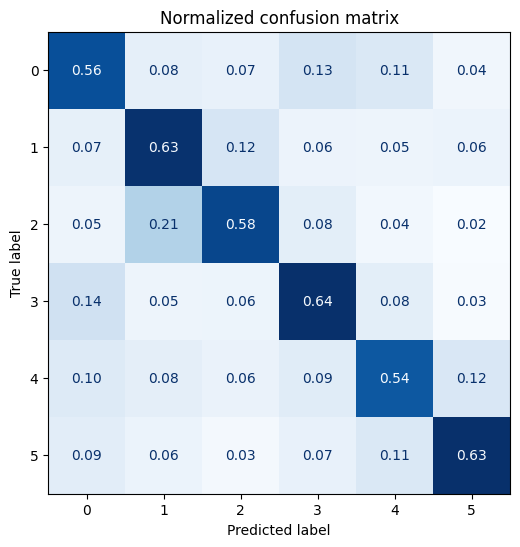

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

plot_confusion_matrix(y_pred, y_val)

# Lets apply more advanced models

In [28]:
# 📦 Imports

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import joblib




# ✅ Define classifiers
models = {
    "LogisticRegression": LogisticRegression(class_weight="balanced", max_iter=1000),
    "SVM": SVC(class_weight="balanced", probability=True),
    "RandomForest": RandomForestClassifier(class_weight="balanced", n_estimators=100, random_state=42),
}

# 🚀 Train and evaluate each model
for name, model in models.items():
    print(f"\n🔧 Training: {name}")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    print(f"📊 {name} - Classification Report:")
    print(classification_report(y_val, y_pred))



🔧 Training: LogisticRegression


/home/silva/HandsOnLLM/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


📊 LogisticRegression - Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.56      0.63       933
           1       0.78      0.63      0.70      1072
           2       0.38      0.59      0.46       261
           3       0.52      0.64      0.57       432
           4       0.48      0.54      0.51       387
           5       0.30      0.63      0.41       115

    accuracy                           0.60      3200
   macro avg       0.53      0.60      0.55      3200
weighted avg       0.64      0.60      0.61      3200


🔧 Training: SVM
📊 SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.52      0.58       933
           1       0.76      0.56      0.64      1072
           2       0.29      0.46      0.36       261
           3       0.45      0.53      0.49       432
           4       0.43      0.49      0.46       387
           5       0.21      0.57     

# Lets try to improve the data quality by scaling 

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


# Lets try again

In [30]:

# 🚀 Train and evaluate each model
for name, model in models.items():
    print(f"\n🔧 Training: {name}")
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_val_scaled)

    print(f"📊 {name} - Classification Report:")
    print(classification_report(y_val, y_pred))



🔧 Training: LogisticRegression
📊 LogisticRegression - Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.55      0.63       933
           1       0.76      0.61      0.68      1072
           2       0.35      0.55      0.43       261
           3       0.50      0.59      0.54       432
           4       0.47      0.55      0.51       387
           5       0.28      0.57      0.38       115

    accuracy                           0.58      3200
   macro avg       0.51      0.57      0.53      3200
weighted avg       0.63      0.58      0.59      3200


🔧 Training: SVM
📊 SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.61      0.64       933
           1       0.72      0.66      0.69      1072
           2       0.37      0.46      0.41       261
           3       0.49      0.57      0.52       432
           4       0.48      0.52      0.50       387
      

In [40]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(512, 256),  # You can tune this
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
    early_stopping=True,            # Automatically stop if no improvement
    verbose=True
)

mlp.fit(X_train_scaled, y_train)




Iteration 1, loss = 1.24682248
Validation score: 0.559375
Iteration 2, loss = 0.93783262
Validation score: 0.569531
Iteration 3, loss = 0.78253913
Validation score: 0.588281
Iteration 4, loss = 0.65144283
Validation score: 0.596094
Iteration 5, loss = 0.53075963
Validation score: 0.590625
Iteration 6, loss = 0.42996762
Validation score: 0.610156
Iteration 7, loss = 0.33685027
Validation score: 0.599219
Iteration 8, loss = 0.26648701
Validation score: 0.589844
Iteration 9, loss = 0.19313308
Validation score: 0.596094
Iteration 10, loss = 0.14412386
Validation score: 0.598437
Iteration 11, loss = 0.09116870
Validation score: 0.591406
Iteration 12, loss = 0.06827383
Validation score: 0.607031
Iteration 13, loss = 0.04883447
Validation score: 0.590625
Iteration 14, loss = 0.04805806
Validation score: 0.601562
Iteration 15, loss = 0.03252534
Validation score: 0.598437
Iteration 16, loss = 0.04316246
Validation score: 0.589063
Iteration 17, loss = 0.04300351
Validation score: 0.594531
Valida

MLPClassifier(early_stopping=True, hidden_layer_sizes=(512, 256), max_iter=500,
              random_state=42, verbose=True)

In [41]:
y_pred = mlp.predict(X_val_scaled)
print("📊 MLP Classifier Report:")
print(classification_report(y_val, y_pred))

📊 MLP Classifier Report:
              precision    recall  f1-score   support

           0       0.60      0.67      0.63       933
           1       0.64      0.79      0.71      1072
           2       0.43      0.23      0.30       261
           3       0.59      0.49      0.53       432
           4       0.55      0.40      0.46       387
           5       0.42      0.21      0.28       115

    accuracy                           0.60      3200
   macro avg       0.54      0.47      0.49      3200
weighted avg       0.59      0.60      0.59      3200



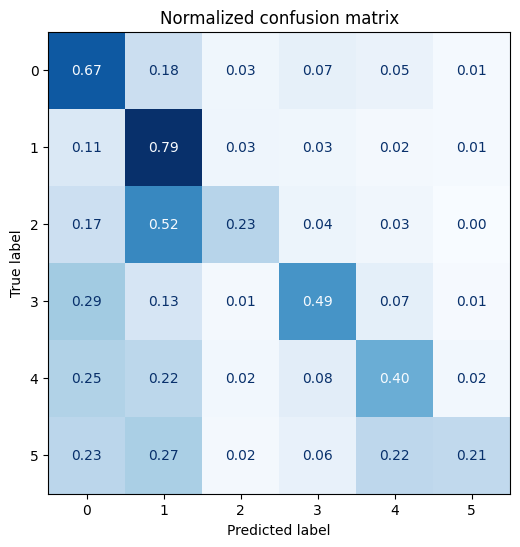

In [42]:
plot_confusion_matrix(y_pred, y_val)